In [152]:
import pandas as pd
import contractions
import re
import nltk
import string
from nltk.tokenize import  word_tokenize
import numpy as np
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [153]:
pip install stop_words

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [154]:
df = pd.read_csv('question_responce.csv')	

In [155]:
df['responce']

0       @115904 We'll be sure to pass along your kind ...
1       @115904 Our apologies for the delay in respond...
2       @115905 Aww, that's definitely a future pilot ...
3               @115906 We're sorry for your frustration.
4       @115909 We're glad you got to kick back and en...
                              ...                        
1847    @172376 We know staying connected is important...
1848    @172677 We've capped our fares for nonstop fli...
1849    @143005 Please give our Baggage team a call at...
1850    @143005 Our apologies for the hold. Our Centra...
1851    @172730 We're providing waivers for St Croix, ...
Name: responce, Length: 1852, dtype: object

In [156]:
df.head()

,Unnamed: 0,responce,question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ..."


    • Tokenization
    • Stopwords removal
    • Lowercasing
    • Stemming/Lemmatization
    • Punctuation removal
    • Emoji hadling (translation into symbols or deletion)
    • Removing noise (URLs, hashtags, …)
    • Removing non-english words

In [157]:
#preprocessing


def remove_punctuation(word_list):
    PUNCUATION_LIST = list(string.punctuation)
    return [w for w in word_list if w not in PUNCUATION_LIST]


def preproc_pipe(data):
    
    data = data.dropna()
    data_clean = pd.DataFrame()
    data_clean['text'] = data
    
    #text to lowercase
    data_clean['text'] = data_clean['text'].str.lower()

    #remove URL links
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    data_clean['text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

    #remove placeholders
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'{link}', '', x))
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"\[video\]", '', x))

    #remove HTML reference characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

    #remove handles
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"@([a-zA-Z0-9_]{1,50})","", x))

    #remove non-letter characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

    # Replace contractions with their longer forms 
    data_clean['text'] = data_clean['text'].apply(lambda x:  contractions.fix(x))



    #tokenize
 

    data_clean['tokens'] = data_clean['text'].apply(nltk.word_tokenize)

    #remove punctuation
    data_clean['tokens'] = data_clean['tokens'].apply(remove_punctuation)


   
    #remove stopwords
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words.extend(nltk_words)

    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

    #stemming/lemmatization

      
    lemmatizer = WordNetLemmatizer()
    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

    #remove non english word
    #words = set(nltk.corpus.words.words())
    #data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [w for w in x if w in words])


    return data_clean


df[['responce_clean','token_responce']] = preproc_pipe(df['responce'])
df[['question_clean','token_question']] = preproc_pipe(df['question'])
df.head()


,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]"
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s..."
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun..."
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte..."


In [158]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


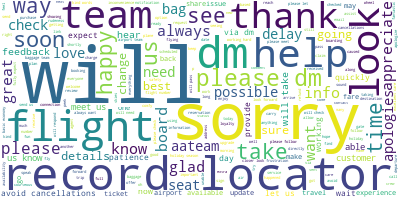

In [159]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(df['responce_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

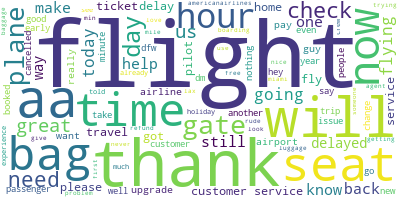

In [160]:
long_string = ','.join(list(df['question_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

TOPIC MODELING LDA

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [161]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [162]:
import gensim.corpora as corpora# Create Dictionary
data_words = df['token_question']
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [163]:
from pprint import pprint# number of topics
import gensim
num_topics = 20# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"flight" + 0.015*"get" + 0.010*"hour" + 0.009*"aa" + 0.008*"another" '
  '+ 0.007*"back" + 0.007*"hey" + 0.007*"thanks" + 0.007*"bag" + 0.006*"day"'),
 (1,
  '0.018*"flight" + 0.014*"time" + 0.012*"check" + 0.011*"bag" + 0.009*"gate" '
  '+ 0.007*"u" + 0.006*"customer" + 0.006*"service" + 0.006*"another" + '
  '0.006*"got"'),
 (2,
  '0.026*"flight" + 0.016*"get" + 0.012*"help" + 0.010*"hour" + 0.008*"gate" + '
  '0.007*"upgrade" + 0.007*"change" + 0.007*"passenger" + 0.006*"delay" + '
  '0.006*"need"'),
 (3,
  '0.018*"flight" + 0.014*"get" + 0.010*"class" + 0.010*"hour" + 0.009*"seat" '
  '+ 0.007*"pay" + 0.007*"first" + 0.007*"aa" + 0.006*"great" + 0.006*"bag"'),
 (4,
  '0.025*"flight" + 0.020*"thanks" + 0.008*"great" + 0.008*"service" + '
  '0.006*"like" + 0.006*"please" + 0.006*"boarding" + 0.006*"know" + '
  '0.006*"help" + 0.006*"today"'),
 (5,
  '0.015*"flight" + 0.011*"aa" + 0.010*"thank" + 0.008*"day" + 0.008*"service" '
  '+ 0.007*"fly" + 0.007*"bag" + 0.007*"cus

In [164]:
! pip install pyLDAvis

In [165]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/home/germain/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of 

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.034052 -0.066261       1        1  8.207440
18     0.072648 -0.003938       2        1  7.301078
13     0.023018 -0.011119       3        1  6.088468
11     0.038738  0.024759       4        1  6.059792
15     0.035935  0.005808       5        1  6.044636
7      0.042520 -0.035532       6        1  5.825484
4     -0.012718  0.018577       7        1  5.688961
0      0.069480  0.003976       8        1  5.632609
9      0.014791  0.022587       9        1  5.111523
6     -0.094555  0.095315      10        1  4.880540
10    -0.015758 -0.027023      11        1  4.687326
5      0.008101 -0.006815      12        1  4.661967
2      0.021335 -0.057888      13        1  4.428629
17     0.004919  0.072703      14        1  4.423147
1     -0.067988 -0.028751      15        1  3.929874
12     0.017146  0.022346      16        1  3.849574
8     -0.044692 -0.059586      17        1  3.719074
3     -0.007657  0.118289      18        1  3.371888
16    -0.002968 -0.027978      19        1  3.326495
14    -0.136348 -0.059468      20        1  2.761498, topic_info=         Term        Freq       Total Category  logprob  loglift
142      seat  112.000000  112.000000  Default  30.0000  30.0000
96     thanks  119.000000  119.000000  Default  29.0000  29.0000
336       get  159.000000  159.000000  Default  28.0000  28.0000
136     class   42.000000   42.000000  Default  27.0000  27.0000
37      thank   81.000000   81.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
128    flying    2.292469   58.870593  Topic20  -5.4130   0.3437
13    airline    2.292794   64.977878  Topic20  -5.4128   0.2451
25       need    2.292864   65.570761  Topic20  -5.4128   0.2361
170  customer    2.292806   94.426746  Topic20  -5.4128  -0.1287
110     thing    1.861869   21.492219  Topic20  -5.6210   1.1433

[1555 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1097     11  0.608627  'one-way
39        1  0.164934        's
39        3  0.041234        's
39        4  0.329869        's
39        5  0.041234        's
...     ...       ...       ...
3283     11  0.907679     youth
622       1  0.204897        yr
622      14  0.409795        yr
622      18  0.204897        yr
622      19  0.204897        yr

[4484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 14, 12, 16, 8, 5, 1, 10, 7, 11, 6, 3, 18, 2, 13, 9, 4, 17, 15])

In [166]:
print('Perplexity: ', lda_model.log_perplexity(corpus))  

Perplexity:  -8.483969637899369


In [167]:
df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]"
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s..."
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun..."
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte..."


SIMILARITY WITH WORD EMBEEDING

In [168]:
print(id2word)

Dictionary<4116 unique tokens: ['amazing', 'erica', 'give', 'lax', 'raise']...>


DICT OF INTENDS